In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

tf.random.set_random_seed(13)

In [2]:
data_path  = "../data/jena_climate_2009_2016.csv"
weather_df = pd.read_csv(data_path)

columns = list(weather_df.columns)
    
new_columns = [
    "datetime",
    "pressure",
    "temp",
    "t_pot",
    "t_dew",
    "rh",
    "vp_max",
    "vp_act",
    "vp_def",
    "sh",
    "water_c",
    "rho",
    "wv",
    "wv_max",
    "wd"
] 

new_col_dict = dict(zip(columns, new_columns))
weather_df = weather_df.rename(columns=new_col_dict)

print("\nNumber of records: {}".format(weather_df.shape[0]))

weather_df.head()


Number of records: 420551


,datetime,pressure,temp,t_pot,t_dew,rh,vp_max,vp_act,vp_def,sh,water_c,rho,wv,wv_max,wd
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


# Univariate

In [3]:
train_split = 300_000

datetime
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: temp, dtype: float64

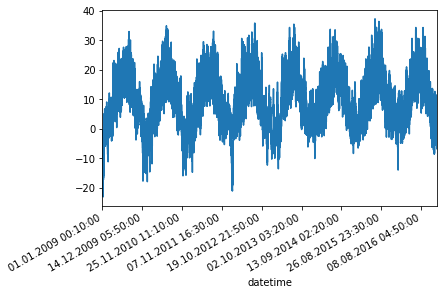

In [4]:
temp_df = weather_df["temp"]
temp_df.index = weather_df["datetime"]
temp_data = temp_df.values

temp_df.plot(subplots=True)

temp_df.head()

In [5]:
train_temp_data = temp_data[:train_split]
test_temp_data  = temp_data[train_split:]

train_mean = train_temp_data.mean()
train_std  = train_temp_data.std()

norm_data = (temp_data - train_mean) / train_std

In [6]:
history_size = 20
target_size  = 0

def time_series_split(input_data, start_index, end_index, history_size, target_size):
        
    data   = []
    labels = []
    
    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(input_data) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        
        reshaped_input = np.reshape(input_data[indices], (history_size, 1))
        
        data.append(reshaped_input)
        labels.append(input_data[i + target_size])
    
    return np.array(data), np.array(labels)

X_train, y_train = time_series_split(
    input_data=norm_data,
    start_index=0,
    end_index=train_split,
    history_size=history_size,
    target_size=target_size
)

X_test, y_test = time_series_split(
    input_data=norm_data,
    start_index=train_split,
    end_index=None,
    history_size=history_size,
    target_size=target_size
)

print("Training data shape: {}".format(X_train.shape))
print("Validation data shape: {}".format(X_test.shape))

Training data shape: (299980, 20, 1)
Validation data shape: (120531, 20, 1)


In [7]:
print ('Single window of past history')
print (X_train[0])
print ('\n Target temperature to predict')
print (y_train[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


<module 'matplotlib.pyplot' from '/home/mickey/.pyenv/versions/tensorflow/lib/python3.6/site-packages/matplotlib/pyplot.py'>

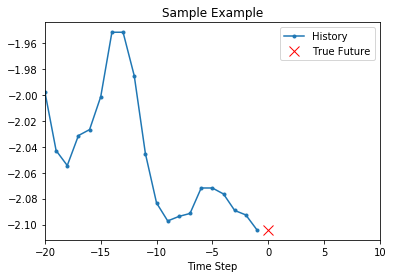

In [8]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length,0,1):
        time_steps.append(i)
    return time_steps

def show_history_plot(plot_data, delta, title):
    labels  = ["History", "True Future", "Model Prediction"]
    markers = [".-", "rx", "go"]
    
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(
                future,
                plot_data[i],
                markers[i],
                markersize=10,
                label=labels[i]
            )
        else:
            plt.plot(
                time_steps,
                plot_data[i].flatten(),
                markers[i],
                label=labels[i]
            )
        
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel("Time Step")
    
    return plt

show_history_plot([X_train[0], y_train[0]], 0, "Sample Example")

<module 'matplotlib.pyplot' from '/home/mickey/.pyenv/versions/tensorflow/lib/python3.6/site-packages/matplotlib/pyplot.py'>

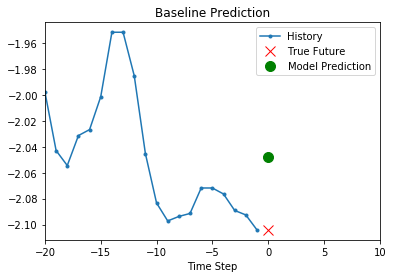

In [9]:
def baseline(history):
    return np.mean(history)

show_history_plot([X_train[0], y_train[0], baseline(X_train[0])] , 0, "Baseline Prediction")

In [10]:
batch_size = 256
buffer_size = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.cache().shuffle(buffer_size).batch(batch_size).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).repeat()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
lstm_model = Sequential([
    LSTM(8, input_shape=X_train.shape[-2:]),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mae")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
predictions = lstm_model.predict(X_test)
print(predictions.shape)

(120531, 1)


In [13]:
eval_interval = 200
epochs = 10

lstm_model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=eval_interval,
    validation_data=test_dataset,
    validation_steps=50
)

Epoch 1/10
200/200 [==============================] - 4s 20ms/step - loss: 0.4367 - val_loss: 0.0921
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1158 - val_loss: 0.0298
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0436 - val_loss: 0.0237
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0394 - val_loss: 0.0209
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0244 - val_loss: 0.0194
Epoch 6/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0266 - val_loss: 0.0185
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0243 - val_loss: 0.0175
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0227 - val_loss: 0.0170
Epoch 9/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0220 - val_loss: 0.0162
Epoch 10/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0202 - val_lo

<module 'matplotlib.pyplot' from '/home/mickey/.pyenv/versions/tensorflow/lib/python3.6/site-packages/matplotlib/pyplot.py'>

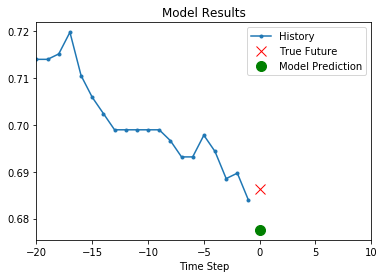

In [14]:
predictions = lstm_model.predict(X_test)

show_history_plot([X_test[100], y_test[100], predictions[100]] , 0, "Model Results")

# Multivariate

In [15]:
del train_dataset
del test_dataset

del X_train
del X_test

del y_train
del y_test

In [16]:
features_considered = [
    "pressure",
    "temp",
    "rho"
]

features = weather_df[features_considered]
features.index = weather_df["datetime"]
features.head()

,pressure,temp,rho
datetime,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc97c3e9668>,
      dtype=object)

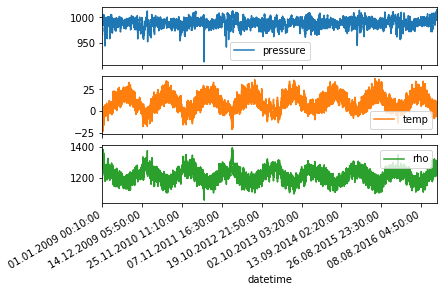

In [17]:
features.plot(subplots=True)

In [18]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

dataset = (dataset - data_mean) / data_std

In [19]:
def multivariate_data(dataset, target, start_ix, end_ix, 
                      history_size, target_size, step, single_step=False):
    data = []
    labels = []
    
    start_ix = start_ix + history_size
    
    if end_ix is None:
        end_ix = len(dataset) - target_size
        
    for i in range(start_ix, end_ix):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
        
    return np.array(data), np.array(labels)

In [20]:
past_history = 24
future_target = 0
step = 6

X_train_single, y_train_single = multivariate_data(
    dataset,
    dataset[:, 1],
    0,
    train_split,
    past_history,
    future_target,
    step,
    single_step=True
)

X_test_single, y_test_single = multivariate_data(
    dataset,
    dataset[:, 1],
    train_split,
    None,
    past_history,
    future_target,
    step,
    single_step=True
)

In [21]:
print ('Single window of past history : {}'.format(X_train_single[0].shape))

Single window of past history : (4, 3)


In [22]:
train_data_single = tf.data.Dataset.from_tensor_slices((X_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(buffer_size).batch(batch_size).repeat()

test_data_single = tf.data.Dataset.from_tensor_slices((X_test_single, y_test_single))
test_data_single = test_data_single.batch(batch_size).repeat()

In [23]:
single_step_model = Sequential([
    LSTM(32, input_shape=X_train_single.shape[-2:]),
    Dense(1)
])

single_step_model.compile(optimizer=RMSprop(), loss="mae")

In [24]:
single_step_history = single_step_model.fit(
    train_data_single, 
    epochs=epochs,
    steps_per_epoch=eval_interval,
    validation_data=test_data_single,
    validation_steps=50
)

Epoch 1/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2332 - val_loss: 0.0903
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0884 - val_loss: 0.0659
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0787 - val_loss: 0.0606
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0670 - val_loss: 0.0549
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0583 - val_loss: 0.0539
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0671 - val_loss: 0.0533
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0644 - val_loss: 0.0527
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0633 - val_loss: 0.0525
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0671 - val_loss: 0.0519
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0632 - val_loss: 0.054

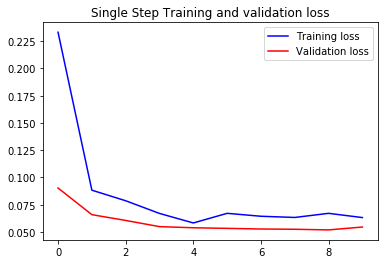

In [25]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

ValueError: x and y must have same first dimension, but have shapes (4,) and (12,)

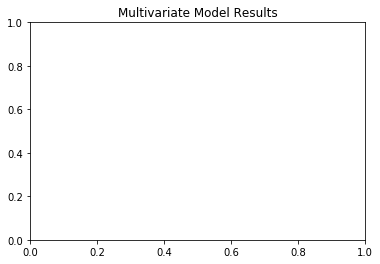

In [26]:
predictions = single_step_model.predict(X_test_single)

show_history_plot([X_test_single[100], y_test_single[100], predictions[100]] , 0, "Multivariate Model Results")